# **CVIV - 2022**

The code is open source so it can be used as an starting point for your personal projects (Ref-ISBN: 9781098102333)

##### **Dataset**
The dataset can be found and freely downloaded from the below links:

- https://www.kaggle.com/competitions/tpu-getting-started/data
- https://www.kaggle.com/competitions/flower-classification-with-tpus/data

# **Always Run The Below Cell**

In [1]:
from google.colab import auth
auth.authenticate_user()
project_id = 'flowerproject-361413'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://104-flowers/


In [2]:
!gcloud beta services identity create --service tpu.googleapis.com --project $project_id

Service identity created: service-1010703852503@cloud-tpu.iam.gserviceaccount.com


In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten
import matplotlib
import math, re, os, sys
import random
from google.colab import drive
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

'''drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/AABC')'''

"drive.mount('/content/drive')\nos.chdir('/content/drive/My Drive/AABC')"

In [3]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.82.135.90:8470']


REPLICAS:  8


## **What are TFRecords?**


> As per Tensorflow's documentation, " ... approach is to convert whatever data you have into a supported format. This approach makes it easier to mix and match data sets and network architectures. The recommended format for TensorFlow is a TFRecords file containing tf.train.Example protocol buffers (which contain Features as a field)."


---


**In Layman's terms, The TFRecord format is a simple format for storing a sequence of binary records.**


---



**Question:** why we even need a container for our image dataset we can simply extract our image into folder, read them into ram and then run, any image classification techniques. 

**Answer:** There are plenty of reasons:

1. Suppose you are experimenting with different image classification algorithms it is beneficial to do basic preprocessing and convert data into format that is faster to load. TFRecord makes that job easier. You can preprocess data and then convert it into TFRecord file. It will save your time and all you need to do read TFRecord file without any preprocessing and then, you can test your ideas on that dataset much faster without going to same step every time. e.g., for pandas it is hdf5 files and for numpy it is npy, similarly for tensorflow, it is tfrecord files.

2. To dynamically shuffle at random places and also change the ratio of **train:test:validate** from the whole dataset. 

**Question:** When you are working with an image dataset, what is the first thing you do? 

**Answer:** Split into Train, Test, Vaildate, sets, and then shuffle to not have any biased data distribution. In case of TFRecord, everything is in a single file and we can use that file to shuffle our dataset.

# Configuration 

- Settings for TPUv3. When running on hardware with less memory such as a TPUv2 (Colab) or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

In [4]:
AUTO = tf.data.experimental.AUTOTUNE
myPath = "gs://practical-ml-vision-book/flowers_104_tfr"
imageSize = [512, 512] # available image sizes in flowers104 dataset are 512x512, 331x331, 224x224, 192x192
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
EPOCHS = 13

# Learning rate schedule traditional
traditional = {
    "LR_START" : 0.00001,
    "LR_MAX" : 0.0001 * strategy.num_replicas_in_sync,
    "LR_MIN" : 0.00001,
    "LR_RAMPUP_EPOCHS" : 0,
    "LR_SUSTAIN_EPOCHS" : 0,
    "LR_EXP_DECAY" : .93
}


# Fine tuned Learning rate schedule with a warmuo ramp
Xception_schedule={
    "LR_START" : 0.00001,
    "LR_MAX" : 0.0001 * strategy.num_replicas_in_sync,
    "LR_MIN" : 0.00001,
    "LR_RAMPUP_EPOCHS" : 3,
    "LR_SUSTAIN_EPOCHS" : 3,
    "LR_EXP_DECAY" : .5    
}

inception_schedule={
    "LR_START" : 0.00001,
    "LR_MAX" : 0.0001 * strategy.num_replicas_in_sync,
    "LR_MIN" : 0.00001,
    "LR_RAMPUP_EPOCHS" : 3,
    "LR_SUSTAIN_EPOCHS" : 1,
    "LR_EXP_DECAY" : .6    
}


pathSelect = { # available image sizes
    192: myPath + '/tfrecords-jpeg-192x192',
    224: myPath + '/tfrecords-jpeg-224x224',
    331: myPath + '/tfrecords-jpeg-331x331',
    512: myPath + '/tfrecords-jpeg-512x512'
}

PATH = pathSelect[imageSize[0]]

# the learning rate scheduling function
# takes the epoch number and the schedule type
# return the learning rate
def lrfn(epoch, Type):
    if epoch < Type["LR_RAMPUP_EPOCHS"]:
        lr = (Type["LR_MAX"] - Type["LR_START"]) / Type["LR_RAMPUP_EPOCHS"] * epoch + Type["LR_START"]
    elif epoch < Type["LR_RAMPUP_EPOCHS"] + Type["LR_SUSTAIN_EPOCHS"]:
        lr = Type["LR_MAX"]
    else:
        lr = (Type["LR_MAX"] - Type["LR_MIN"]) * Type["LR_EXP_DECAY"]**(epoch - Type["LR_RAMPUP_EPOCHS"] - Type["LR_SUSTAIN_EPOCHS"]) + Type["LR_MIN"]
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

- This dataset is split three ways, training, validation, test
- but we will use it split two ways only: combining training and validation for training and using testset for validation

In [5]:
train_files = tf.io.gfile.glob(PATH + '/train/*.tfrec') + tf.io.gfile.glob(PATH + '/val/*.tfrec')
validation_files = tf.io.gfile.glob(PATH + '/test/*.tfrec')

In [6]:
print(len(train_files),len(validation_files))

32 16


In [7]:
# All classes in the dataset (104 flower types)
classes = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']   
len(classes)

104

# we can go with a fine tuned or traditional learning rate schedule
 - For the finetuned we assume only 13 epochs
 - for traditional we assume 40 epochs

Learning rate schedule: 1e-05 to 0.0008 to 2.33e-05


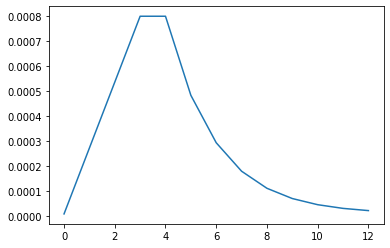

In [8]:
# we go with the fine tuned learning rate schedule first with exponential decay with 13 epochs
rng = [i for i in range(EPOCHS)]
y = [lrfn(x, inception_schedule) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1])) 

Learning rate schedule: 1e-05 to 0.0008 to 2.23e-05


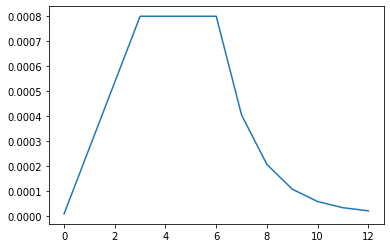

In [35]:
# we go with the fine tuned learning rate schedule first with exponential decay with 13 epochs
rng = [i for i in range(EPOCHS)]
y = [lrfn(x, Xception_schedule) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1])) 

Learning rate schedule: 0.0008 to 0.0008 to 5.66e-05


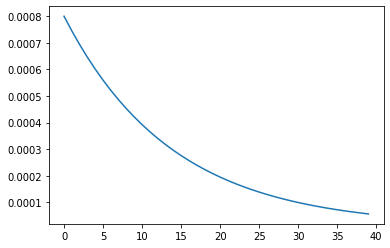

In [37]:
# we go with the traditional learning rate schedule with 40 epochs
rng = [i for i in range(40)]
y = [lrfn(x, traditional) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# All utilities you might need for Visualization in this experiment
- Keep these on hand from  now on



In [9]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return classes[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(classes[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                classes[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else classes[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# All utilities you might need for handling image datasets in TFR format
- Keep these on hand from  now on

In [10]:

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) # decoded inamge in uint8 format range [0,255]
    image = tf.reshape(image, [*imageSize, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    idnum = example['id'] # image id, not used
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(train_files)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(validation_files, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [11]:
NUM_TRAINING_IMAGES = count_data_items(train_files)
NUM_VALIDATION_IMAGES = count_data_items(validation_files)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print("Steps we make per epoch: ", STEPS_PER_EPOCH)
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
print("Steps taken for validation stage:", VALIDATION_STEPS)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Steps we make per epoch:  64
Steps taken for validation stage: 29
Dataset: 16465 training images, 7382 validation images


# Lets use the visulization utilities

In [12]:
# lets see the shape of training data for 10 flowers
print("Training data shapes:")
for image, label in get_training_dataset().take(10):
    print(image.numpy().shape, label.numpy().shape)

# label sample to see how they look
print("Training data label examples:", label.numpy())

Training data shapes:
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
Training data label examples: [ 91  82  43 ...   5 103  47]


In [13]:
# Lets use the visualization tools to see a batch of 100 flowers
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(100)
train_batch = iter(training_dataset)
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

Output hidden; open in https://colab.research.google.com to view.

# **Inception Model**

In [14]:
strategy.scope()

In [44]:
with strategy.scope():
  pretrained = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

  model = tf.keras.Sequential([
      # convert image format from int [0,255] to the format expected by this model
      tf.keras.layers.Lambda(lambda data: tf.keras.applications.inception_v3.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*imageSize, 3]),
      pretrained,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(len(classes), activation='softmax', name='flower_prob')
      ])

In [45]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flower_prob (Dense)         (None, 104)               213096    
                                                                 
Total params: 22,015,880
Trainable params: 21,981,448
Non-trainable params: 34,432
_________________________________________________________________


In [47]:
# Learning rate schedule
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 1
LR_EXP_DECAY = .6

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/13
64/64 [==============================] - 158s 2s/step - loss: 4.2966 - sparse_categorical_accuracy: 0.1410 - val_loss: 3.8830 - val_sparse_categorical_accuracy: 0.2449 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.0002733333333333334.
Epoch 2/13
64/64 [==============================] - 43s 676ms/step - loss: 1.3455 - sparse_categorical_accuracy: 0.6999 - val_loss: 0.7963 - val_sparse_categorical_accuracy: 0.7946 - lr: 2.7333e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005366666666666667.
Epoch 3/13
64/64 [==============================] - 43s 674ms/step - loss: 0.4470 - sparse_categorical_accuracy: 0.8895 - val_loss: 1.3380 - val_sparse_categorical_accuracy: 0.6622 - lr: 5.3667e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008.
Epoch 4/13
64/64 [==============================] - 43s 676ms/step - loss: 0.3514 - sparse_categorical_accuracy: 0.9069

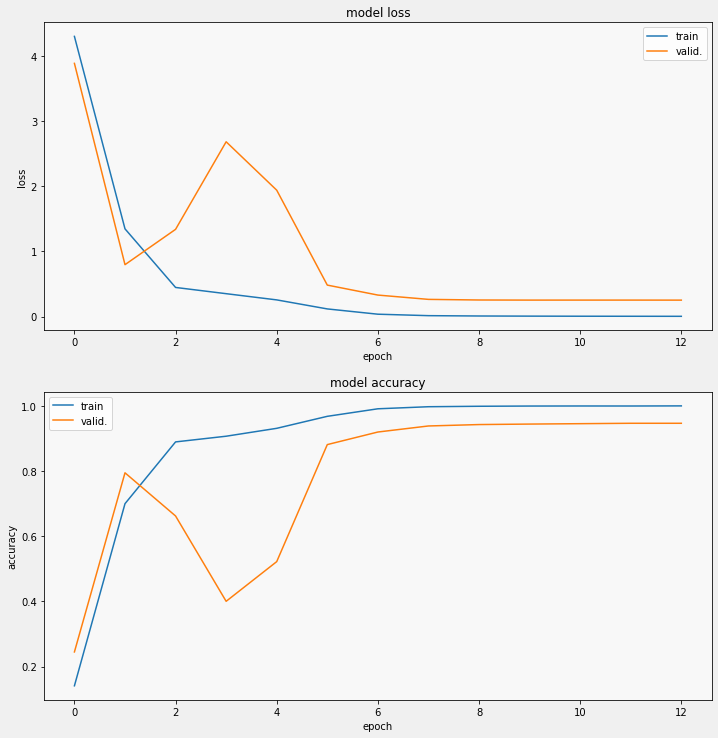

In [48]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)


In [49]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (7382,) [ 67  28  83 ...  95 102  62]
Predicted labels:  (7382,) [ 67  28  83 ...  73 102  62]


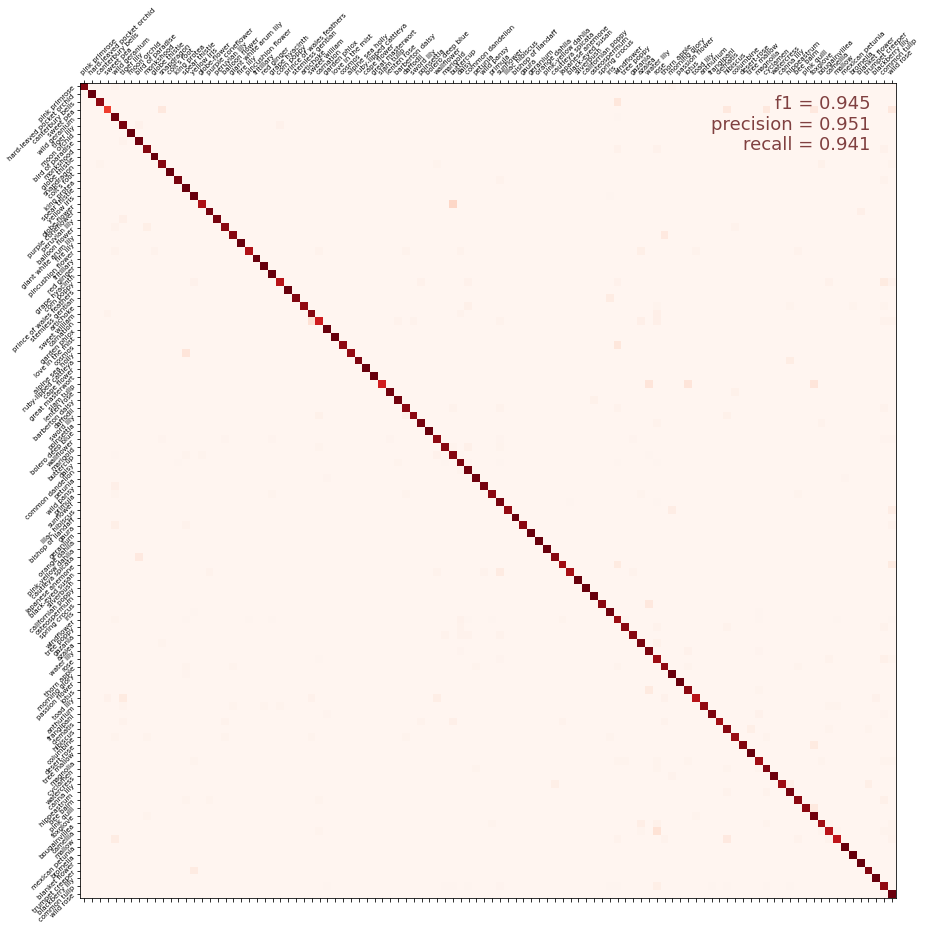

f1 score: 0.945, precision: 0.951, recall: 0.941


In [51]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(classes)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(classes)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(classes)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(classes)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [52]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

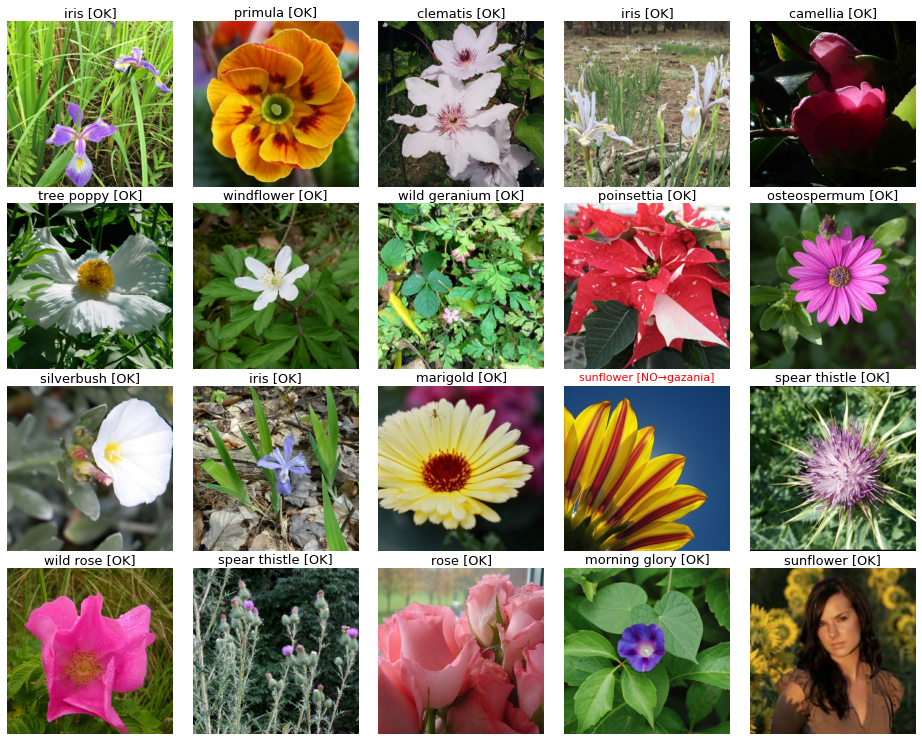

In [53]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Xception model


In [18]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
    #pretrained_model = efficientnet.tfkeras.EfficientNetB7(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # fine-tuning
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*imageSize, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(classes), activation='softmax', name='flower_prob')
    ])
    
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 512, 512, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flower_prob (Dense)         (None, 104)               213096    
                                                                 
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
# Learning rate schedule
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])

Epoch 1/13

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
64/64 [==============================] - 89s 1s/step - loss: 4.5619 - sparse_categorical_accuracy: 0.0492 - val_loss: 4.2986 - val_sparse_categorical_accuracy: 0.1791
Epoch 2/13

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002733333333333334.
64/64 [==============================] - 30s 463ms/step - loss: 2.5517 - sparse_categorical_accuracy: 0.4804 - val_loss: 0.8308 - val_sparse_categorical_accuracy: 0.8003
Epoch 3/13

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005366666666666667.
64/64 [==============================] - 30s 461ms/step - loss: 0.5458 - sparse_categorical_accuracy: 0.8763 - val_loss: 0.4860 - val_sparse_categorical_accuracy: 0.8826
Epoch 4/13

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0008.
64/64 [==============================] - 30s 461ms/step - loss: 0.2259 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.7530 - val_sparse

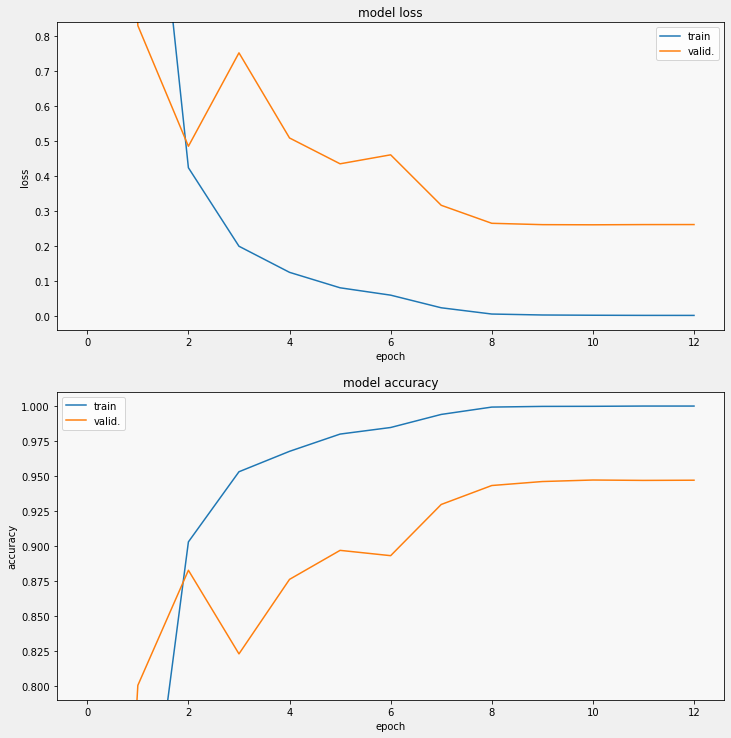

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, ylim=[0, 0.8])
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212, ylim=[0.8, 1])


In [ ]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (7382,) [ 67  28  83 ...  95 102  62]
Predicted labels:  (7382,) [ 67  28  83 ...  86 102  62]


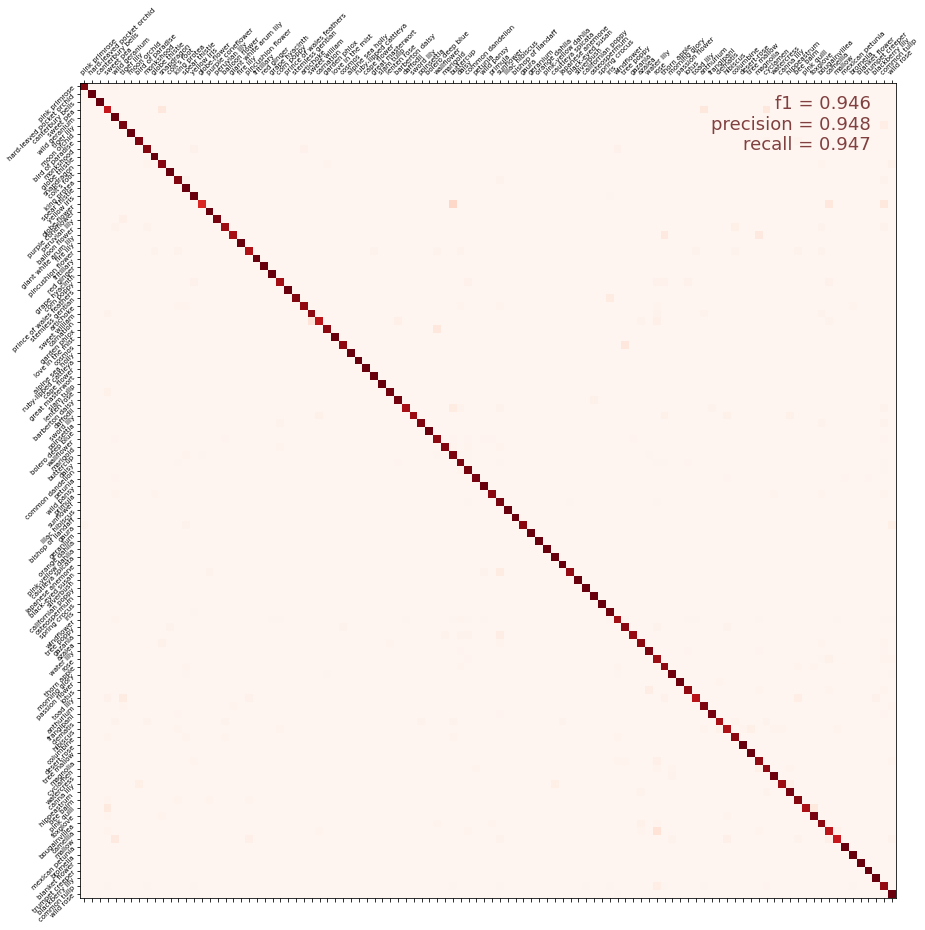

f1 score: 0.946, precision: 0.948, recall: 0.947


In [ ]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

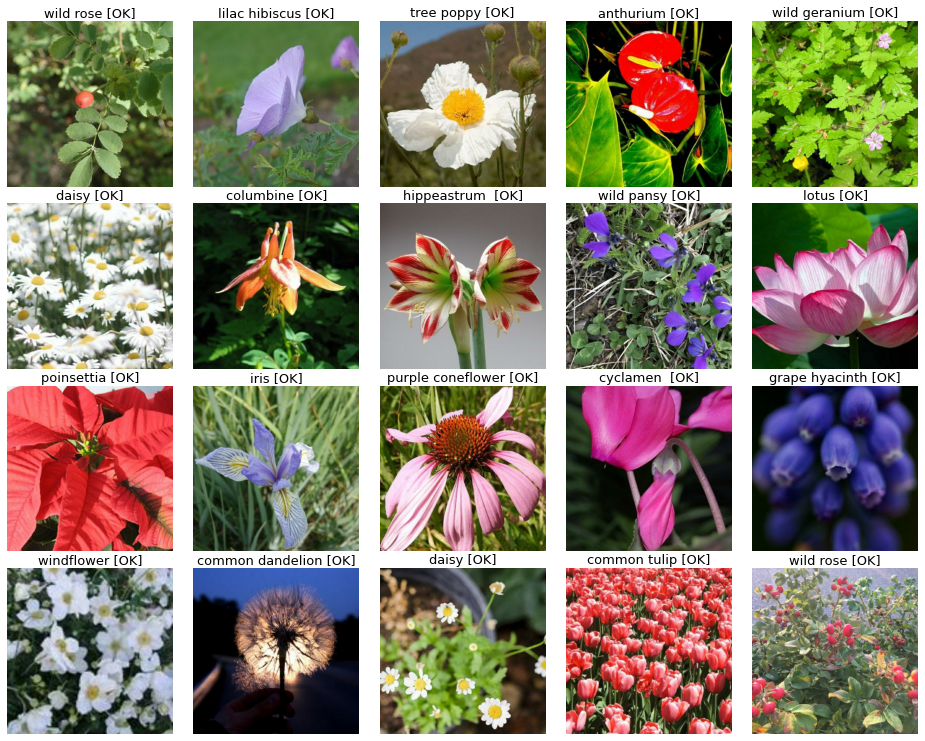

In [ ]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)